# Natural Language Processing with Disaster Tweets
Kaggle Mini-Project week 4

Dillon Tiller

https://github.com/DillonKyle/deep-learning-wk4

## Description

This project will aims to look at tweets and determine if the poster intended to alert others of a disaster or if they were just using hyperbolic language

### The Data
This project uses 2 CSV datasets, one for testing and one for training. The training dataset consists of 5 columns:
- id
- keyword - identifies the word related to a disaster
- location - geographical location of the tweet
- text - the body of the tweet
- target - the binary classification of the tweet
with 10,873 records.

The test dataset contains the same columns, minus the 'target' column, since the classification targets are unknown and contains 10,875 records





## Exploratory Data Analysis

In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns

### Cleaning the Data
We will start by loading the data from the training set into a dataframe, checking and fixing any null values, checking and removing any duplicates, and cleaning unwanted symbols from the text 

In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
df['keyword'].fillna('Unknown', inplace=True)
df['location'].fillna('Unknown', inplace=True)
df.isnull().sum()

C:\Users\dillo\AppData\Local\Temp\ipykernel_6644\2853873676.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('Unknown', inplace=True)
C:\Users\dillo\AppData\Local\Temp\ipykernel_6644\2853873676.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove hashtags and special characters
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,id,keyword,location,text,target,cleaned_text
0,1,Unknown,Unknown,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Unknown,Unknown,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,Unknown,Unknown,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,Unknown,Unknown,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,Unknown,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...


### Analysis of the Data

Now that we've cleaned the data we can explore it further, starting with some inspection functions and moving into plotting the relationships between the values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7613 non-null   object
 2   location      7613 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   cleaned_text  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


In [9]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


We can also look at the distibution of the binary classification from the target column

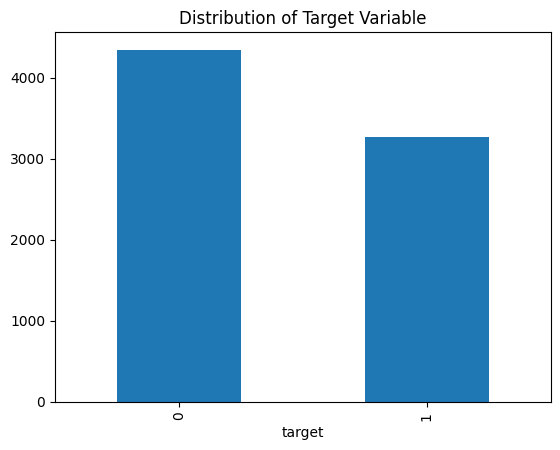

In [10]:
df['target'].value_counts().plot(kind='bar', title='Distribution of Target Variable');


Now we will analyze the length of the text in each row, as longer texts may provide more context.

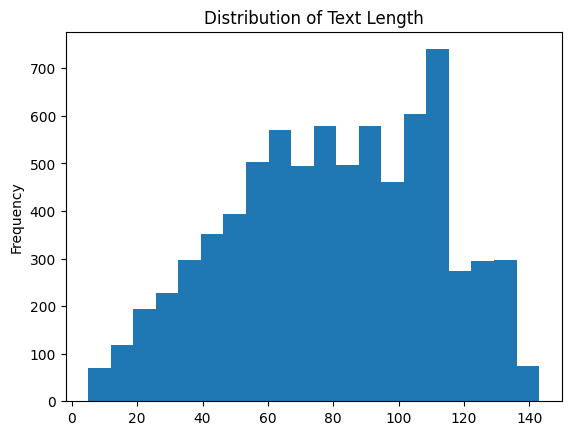

In [11]:
df['text_length'] = df['cleaned_text'].apply(len)
df['text_length'].plot(kind='hist', bins=20, title='Distribution of Text Length');


Lets plot the most frequent keywords

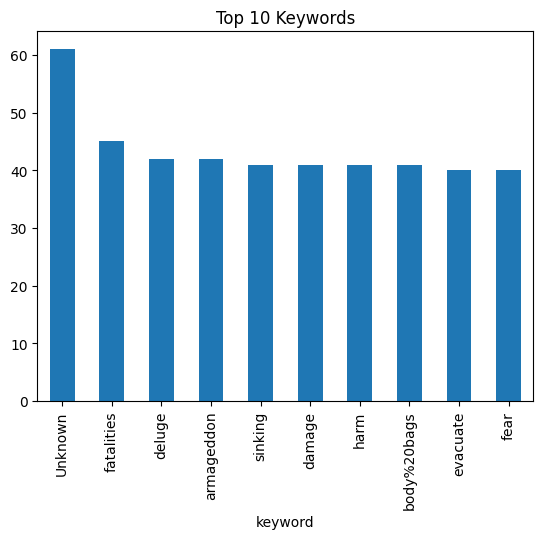

In [12]:
df['keyword'].value_counts().head(10).plot(kind='bar', title='Top 10 Keywords');


Lets check if there is any correlation between the text length and the target variable.

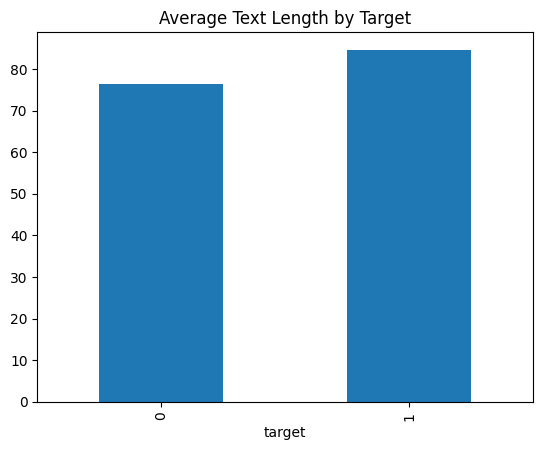

In [13]:
df.groupby('target')['text_length'].mean().plot(kind='bar', title='Average Text Length by Target');


## Model Architectrue
For this project, we will start by using TF-IDF to convert the raw texts into a matrix form of 5000 features.

For our model, we will use an LSTM model which is designed to handle the sequential, text based data that is in our dataset.

In [14]:

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features

# Fit and transform the 'cleaned_text' column into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()

# Check the shape of the resulting matrix
X_tfidf.shape  # This will show the number of samples and the number of features (5000 in this case)

(7613, 5000)

In [15]:
# Define the LSTM model
model = Sequential()

# Add an embedding layer
# Note: Input size is X_tfidf.shape[1] because it represents the TF-IDF matrix (5000 features)
model.add(Embedding(input_dim=X_tfidf.shape[1], output_dim=128, input_length=X_tfidf.shape[1]))

# Add an LSTM layer
model.add(LSTM(units=128, return_sequences=False))  # 128 LSTM units

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add a dense output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



c:\Users\dillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['target'], test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 775s 4s/step - accuracy: 0.5733 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4409s 23s/step - accuracy: 0.5643 - loss: 0.6860 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1064s 5s/step - accuracy: 0.5553 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.5662 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.5730 - loss: 0.6832 - val_accuracy: 0.5739 - val_loss: 0.6835


### Tune Hyperparameters on various models

From running the model above, we can see that LSTM performed with an accuracy of _ after 5 epochs. Lets try running SimpleRNN and GRU models along with LSTM and find the best model and hyperparameters to use.

In [17]:
class HyperparameterTuner:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.results = []

    def build_model(self, model_type, units, dropout_rate, learning_rate):
        model = Sequential()
        
        # Choose the type of RNN model
        if model_type == 'LSTM':
            model.add(LSTM(units, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        elif model_type == 'SimpleRNN':
            model.add(SimpleRNN(units, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))
        elif model_type == 'GRU':
            model.add(GRU(units, input_shape=(self.X_train.shape[1], self.X_train.shape[2])))

        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def tune_model(self, model_type, units_list, dropout_rate_list, learning_rate_list, epochs=5, batch_size=32):
        for units in units_list:
            for dropout_rate in dropout_rate_list:
                for learning_rate in learning_rate_list:
                    # Build model
                    model = self.build_model(model_type, units, dropout_rate, learning_rate)
                    # Train model
                    history = model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, 
                                        validation_data=(self.X_test, self.y_test), verbose=0)
                    # Get final validation accuracy
                    val_accuracy = history.history['val_accuracy'][-1]
                    # Store the results
                    self.results.append({
                        'model_type': model_type,
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'val_accuracy': val_accuracy
                    })
                    print(f"{model_type}: Units={units}, Dropout={dropout_rate}, LR={learning_rate}, Accuracy={val_accuracy:.4f}")

    def plot_results(self):
        # Convert results to DataFrame for easy visualization
        import pandas as pd
        results_df = pd.DataFrame(self.results)

        # Plot the accuracies for each model type
        plt.figure(figsize=(10, 6))
        for model_type in results_df['model_type'].unique():
            model_results = results_df[results_df['model_type'] == model_type]
            plt.plot(model_results['val_accuracy'], label=model_type)

        plt.title('Validation Accuracy for Different Models')
        plt.xlabel('Hyperparameter Combination Index')
        plt.ylabel('Validation Accuracy')
        plt.legend()
        plt.show()

        # Show the best hyperparameters
        best_result = results_df.loc[results_df['val_accuracy'].idxmax()]
        print(f"Best Model: {best_result['model_type']} with units={best_result['units']}, "
              f"dropout_rate={best_result['dropout_rate']}, learning_rate={best_result['learning_rate']}")


In [18]:

# Reshape the input for RNN models (needed if using TF-IDF or similar input)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

c:\Users\dillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM: Units=32, Dropout=0.2, LR=0.001, Accuracy=0.7951
LSTM: Units=32, Dropout=0.2, LR=0.01, Accuracy=0.7597
LSTM: Units=32, Dropout=0.3, LR=0.001, Accuracy=0.7997
LSTM: Units=32, Dropout=0.3, LR=0.01, Accuracy=0.7636
LSTM: Units=32, Dropout=0.4, LR=0.001, Accuracy=0.7965
LSTM: Units=32, Dropout=0.4, LR=0.01, Accuracy=0.7564
LSTM: Units=64, Dropout=0.2, LR=0.001, Accuracy=0.7991
LSTM: Units=64, Dropout=0.2, LR=0.01, Accuracy=0.7597
LSTM: Units=64, Dropout=0.3, LR=0.001, Accuracy=0.7965
LSTM: Units=64, Dropout=0.3, LR=0.01, Accuracy=0.7649
LSTM: Units=64, Dropout=0.4, LR=0.001, Accuracy=0.8004
LSTM: Units=64, Dropout=0.4, LR=0.01, Accuracy=0.7656
LSTM: Units=128, Dropout=0.2, LR=0.001, Accuracy=0.7833
LSTM: Units=128, Dropout=0.2, LR=0.01, Accuracy=0.7617
LSTM: Units=128, Dropout=0.3, LR=0.001, Accuracy=0.7873
LSTM: Units=128, Dropout=0.3, LR=0.01, Accuracy=0.7695
LSTM: Units=128, Dropout=0.4, LR=0.001, Accuracy=0.7938
LSTM: Units=128, Dropout=0.4, LR=0.01, Accuracy=0.7590
SimpleRNN: Un

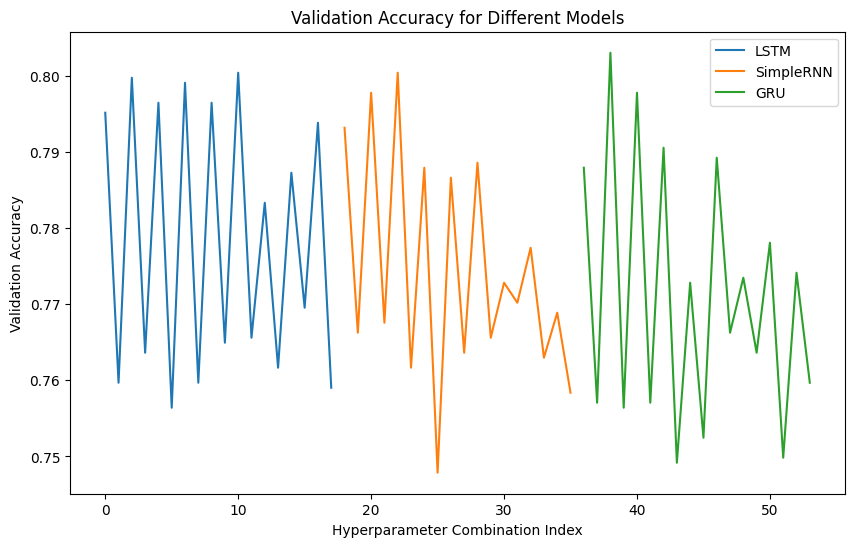

Best Model: GRU with units=32, dropout_rate=0.3, learning_rate=0.001


In [19]:
# Instantiate the hyperparameter tuner
tuner = HyperparameterTuner(X_train_rnn, y_train, X_test_rnn, y_test)

# Define hyperparameter ranges
units_list = [32, 64, 128]
dropout_rate_list = [0.2, 0.3, 0.4]
learning_rate_list = [0.001, 0.01]

# Tune the LSTM model
tuner.tune_model('LSTM', units_list, dropout_rate_list, learning_rate_list, epochs=5)

# Tune the SimpleRNN model
tuner.tune_model('SimpleRNN', units_list, dropout_rate_list, learning_rate_list, epochs=5)

# Tune the GRU model
tuner.tune_model('GRU', units_list, dropout_rate_list, learning_rate_list, epochs=5)

# Plot the results and show the best model
tuner.plot_results()

In [21]:
model = Sequential()
model.add(GRU(32, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_rnn, y_train, epochs=5, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/5


c:\Users\dillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5887 - loss: 0.6693 - val_accuracy: 0.7649 - val_loss: 0.5770
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8013 - loss: 0.5151 - val_accuracy: 0.8024 - val_loss: 0.4718
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8566 - loss: 0.3818 - val_accuracy: 0.8050 - val_loss: 0.4507
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8746 - loss: 0.3127 - val_accuracy: 0.7991 - val_loss: 0.4571
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8954 - loss: 0.2787 - val_accuracy: 0.7984 - val_loss: 0.4726


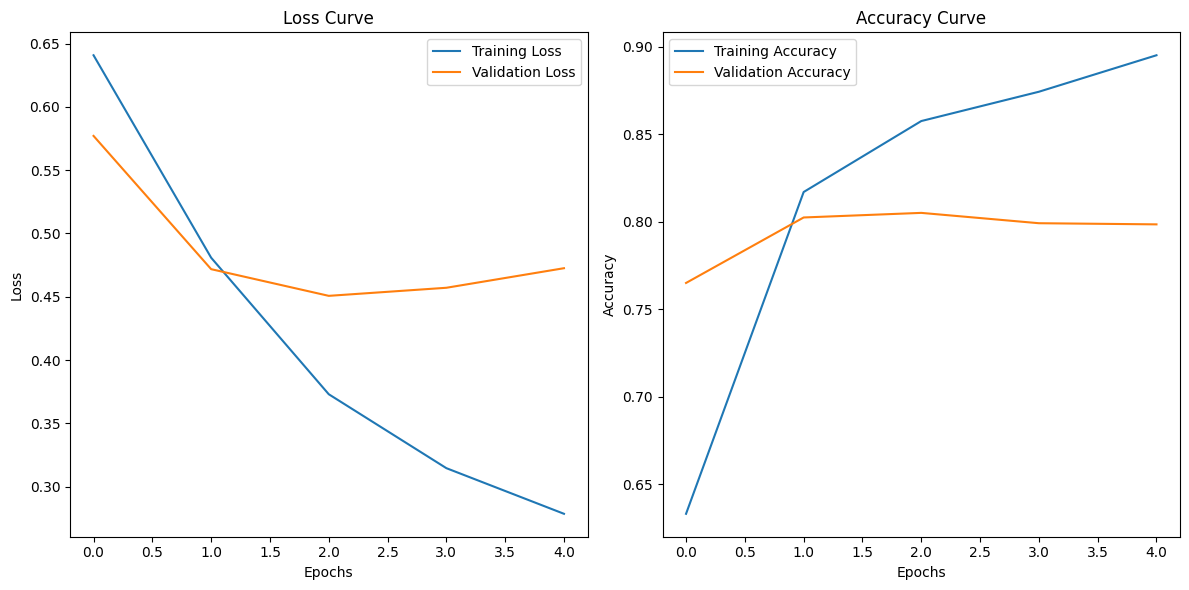

In [22]:

# Plot the loss and accuracy curves
def plot_model_history(history):
    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(history)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


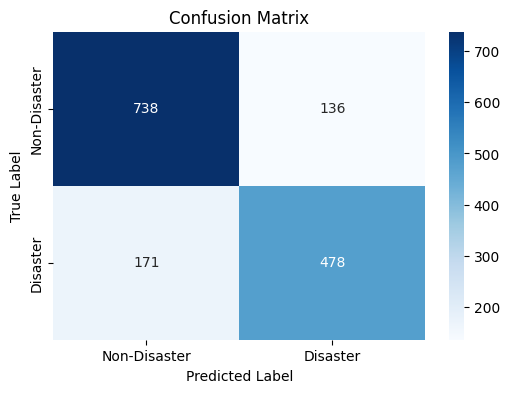

In [24]:
# Predict on the test set
y_pred = (model.predict(X_test_rnn) > 0.5).astype('int32')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


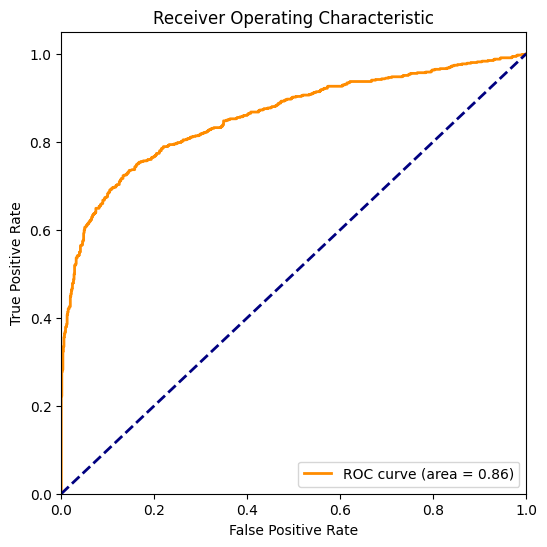

In [25]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test_rnn))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


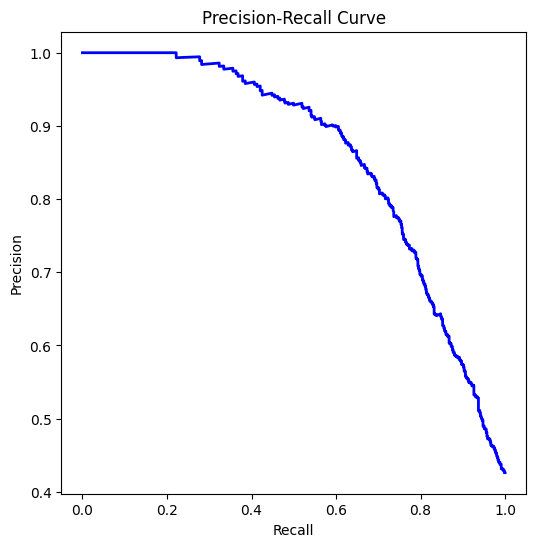

In [26]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, model.predict(X_test_rnn))

# Plot Precision-Recall curve
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, lw=2, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()